### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from urllib.parse import parse_qs
import numpy as np
from scipy.optimize import minimize
import seaborn as sns

# Evaluating Watches as Assets in a Portfolio (Efficient Frontier)

##  Frontier Primer

The Efficient Frontier is a concept from Modern Portfolio Theory introduced by Harry Markowitz in his 1952 paper, "Portfolio Selection". The Efficient Frontier represents a set of portfolios that are considered optimally diversified, providing the highest possible expected return for a given level of risk. In other words, any portfolio that lies on the Efficient Frontier is expected to achieve the best possible return for its level of risk, assuming that returns are normally distributed. (ChatGPT)

In the context of the **`WatchCollection`** class, each **`Watch`** instance represents a different investment asset, in this case, a different watch. The **`calculate_efficient_frontier`** method computes the Efficient Frontier for a collection of watches. It does this by calculating the expected returns and the covariance matrix for the set of watches, then using optimization techniques to find the set of portfolio weights that minimize the portfolio's volatility for a range of target returns. Each portfolio's volatility and expected return are then plotted on a graph, with volatility on the x-axis and expected return on the y-axis. This graph is known as the Efficient Frontier.

The **`get_min_vol_weights`** method returns the portfolio weights for the portfolio with the lowest volatility among those on the Efficient Frontier. This portfolio is also known as the "Minimum-Variance Portfolio". This portfolio is expected to provide the best possible return for the lowest level of risk.

It's important to note that this analysis makes several assumptions, including that the returns of the watches are normally distributed and that the relationships between the watches remain constant over time. These assumptions may not hold true in reality, and as such, any investment decisions should not be made solely based on this analysis. It is always recommended to use such models as part of a broader analysis that includes other factors and risk considerations.

## Code and Python Class
### Fetch and Data Source
Before analyzing the performance of watches as investment assets, we need to obtain their historical price data. To achieve this, we inspected the www.watchpricetrend.com website and identified the underlying request it uses to fetch the data. We then employ the requests library to replicate this GET request, allowing us to access the historical price data for various watches.Initially the the fetch wouldn't work so we copied the request from the browser to postman and created this python request function and modified it.

In [2]:
params_list = []
watches_url = [
    'id_reference=16&name_reference=16570%20cal.%203186&groupby=&currency=chf', # Rolex Explorer II 16570
    'id_reference=45&name_reference=3712%201A&groupby=&currency=chf', # Patek Philippe Nautilus
    'id_reference=21&name_reference=1675&groupby=&currency=chf', # Rolex GMT-Master 1675
    'id_reference=66&name_reference=166.077&groupby=&currency=chf', # Omega Seamaster Ploprof 166.077
    # 'id_reference=97&name_reference=Jumbo%2015202ST&groupby=&currency=chf' # Royal Oak
]

# parse string to dict for request
for watch in watches_url:
    params_list.append({k: v[0] for k, v in parse_qs(watch).items()})

# API request (with use of POSTMAN)
def fetch(params):
  payload={}
  url = 'https://www.watchpricetrend.com/cost/query/xhr/query.xhr.php'
  headers = {
    'Cookie': '_ga=GA1.2.7954034.1684268134; _gid=GA1.2.1673098656.1684268134; PHPSESSID=k118sgavi68qsh6diafi6r6cj6',
    'Accept': '*/*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Host': 'www.watchpricetrend.com',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Accept-Language': 'en-GB,en;q=0.9',
    'Referer': 'https://www.watchpricetrend.com/Patek+Philippe_Nautilus_3712+1A-45.html',
    'Connection': 'keep-alive'
  }
  response = requests.request("GET", url,params=params, headers=headers, data=payload)
  response_dict = json.loads(response.text)
  return response_dict["results"], params['name_reference']

### WatchCollection and Watch Class

#### The Watch Class
 represents a watch as an investment asset. It takes the historical price data of the watch and calculates the percentage change in price over time. It also calculates the mean and standard deviation of these percentage changes, which will be used later in the analysis.

#### The WatchCollection Class
is a collection of Watch objects. It provides methods to add watches to the collection, visualize the price data, and calculate the efficient frontier.

In [3]:
class Watch:
    '''
    Holds Data for 1 Watch
'''
    def __init__(self, data, name_reference):
        self.name_reference = name_reference
        self.data = pd.DataFrame(data)
        self.data = self.data.iloc[:-2]
        self.data['date'] = self.data['date'].apply(lambda x: pd.to_datetime(f'{x}-1', format='%Y-%W-%w'))
        self.data[self.name_reference] = pd.to_numeric(self.data[self.name_reference])
        self.data['Percentage Change'] = self.data[self.name_reference].pct_change()
        self.mean = self.data['Percentage Change'].mean()
        self.std = self.data['Percentage Change'].std()

class WatchCollection:
    '''
    Watch portfolio class with add_watch, DataCleaning, Calculation and Plotting functions
    ''' 

    def __init__(self):
        self.watches = []

    def add_watch(self, data, name_reference):
        self.watches.append(Watch(data, name_reference))

    def plot(self):
        '''
        Plot Time Series of Watches in Portfolio Indexed to 100.
        '''
        plt.figure(figsize=(10, 5))
        for watch in self.watches:
            indexed_data = watch.data[watch.name_reference] / watch.data[watch.name_reference].iloc[0] * 100
            plt.plot(watch.data['date'], indexed_data, label=watch.name_reference)
            
        plt.xlabel('Date')
        plt.ylabel("Indexed Price")
        plt.title('Time series of Watches')
        plt.grid(True)
        plt.xlim(min(min(watch.data['date']) for watch in self.watches), max(max(watch.data['date']) for watch in self.watches))
        plt.legend()
        plt.show()

    def get_dataframe(self):
        '''
        Clean, Merge Datasets and Calculate Monthly % Returns
        '''
        dataframes = []
        # merge with correct timestamp
        for watch in self.watches:
            dataframes.append(watch.data[['date', watch.name_reference]].set_index('date'))
        combined_df = pd.concat(dataframes, axis=1)

        # Drop rows from the start of the DataFrame that contain NaN values
        while combined_df.iloc[0].isna().any():
            combined_df = combined_df.iloc[1:]
    
        # Drop rows from the end of the DataFrame that contain NaN values
        while combined_df.iloc[-1].isna().any():
            combined_df = combined_df.iloc[:-1]

        # Interpolate missing values linearly    
        combined_df.interpolate(method='linear', inplace=True)
        df_pct_change = combined_df.pct_change()
        df_pct_change = df_pct_change.dropna()
        return df_pct_change

    def calculate_efficient_frontier(self):
        '''
        Function to calculate Efficient Frontier using SLSQP
        '''
        df = self.get_dataframe() # Get cleaned Dataset
        noa = len(df.columns)  # number of assets
        returns = df.mean()   # annualize returns
        cov_matrix = df.cov()  # annualize covariance matrix

        def portfolio_performance(weights):
            return np.sum(returns * weights), np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        def minimize_volatility(weights):
            return portfolio_performance(weights)[1]

        initial_guess = noa * [1. / noa,]  # equal weighting
        bounds = tuple((0, 1) for asset in range(noa))
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        optimal_portfolio_volatility = minimize(minimize_volatility, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

        target_returns = np.linspace(returns.min(), returns.max(), 50)
        target_volatilities = []

        for target_return in target_returns:
            constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target_return},
                           {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            res = minimize(minimize_volatility, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
            target_volatilities.append(res['fun'])
        
        self.target_returns = target_returns
        self.target_volatilities = target_volatilities

    def get_min_vol_weights(self):
        '''
        Get Portfolio weights for Minimum Variance Portfolio
        '''
        # almost same steps of calculate_efficient_frontier() but retruning min weigths.
        df = self.get_dataframe()
        
        # This function calculates the portfolio volatility
        def calculate_portfolio_volatility(weights):
            return np.sqrt(np.dot(weights.T, np.dot(df.cov(), weights)))
        
        # Initial guess for weights (equal distribution)
        num_watches = len(df.columns)
        init_guess = np.repeat(1 / num_watches, num_watches)
        
        # Constraints: weights must sum to 1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        
        # Bounds: each weight can be between 0 and 1
        bounds = tuple((0, 1) for _ in range(num_watches))
        
        # Perform the minimization
        min_vol_result = minimize(calculate_portfolio_volatility, init_guess,
                                  method='SLSQP', bounds=bounds, constraints=constraints)

        if not min_vol_result.success:
            raise Exception('Minimization did not converge: ', min_vol_result.message)

        # Return the optimal weights
        return min_vol_result.x

    def plot_efficient_frontier(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.target_volatilities, self.target_returns, c=self.target_returns / np.array(self.target_volatilities), marker='x')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label='Sharpe ratio')
        plt.title('Efficient Frontier [ Weekly ]')
        plt.show()


## Findings

### Setup and Data Fetching

In [4]:
# Init Watch Portfolio
watch_collection = WatchCollection()

# Scrape Data from Website for all Watches and add them to the Portfolio
for param in params_list:
    data, ref = fetch(param)
    watch_collection.add_watch(data,ref)

### Examine Data and Visualize

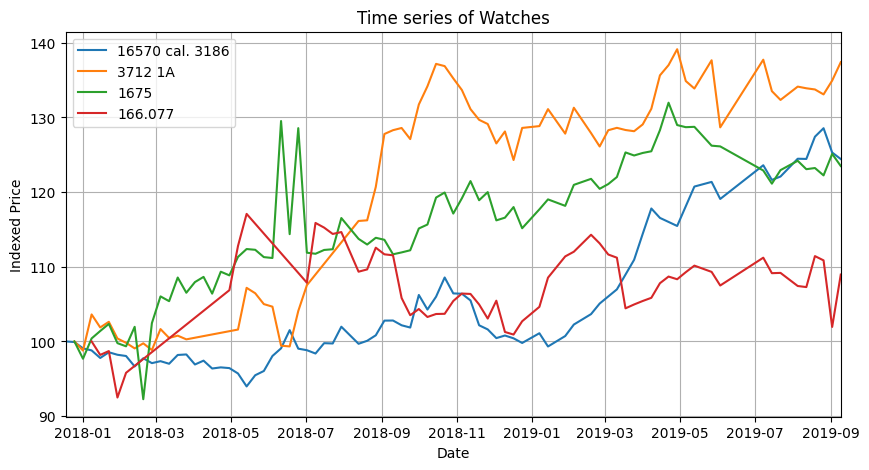

In [5]:
# Plot Time Series of Watch Prices Indexed to 100
watch_collection.plot()

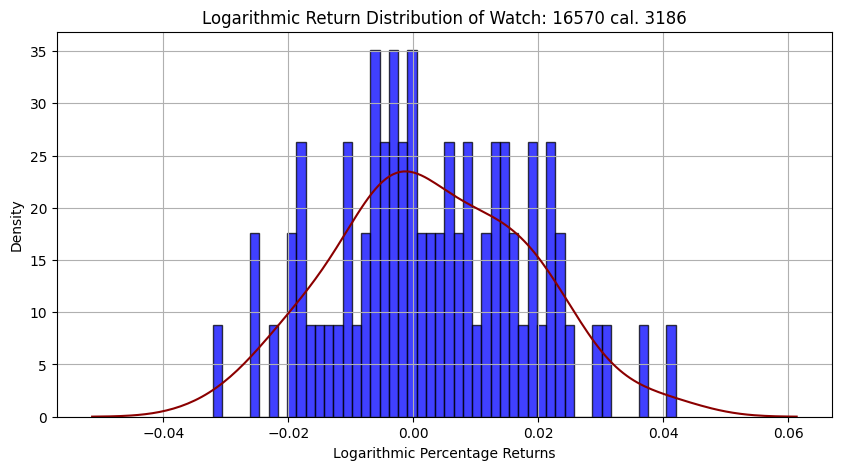

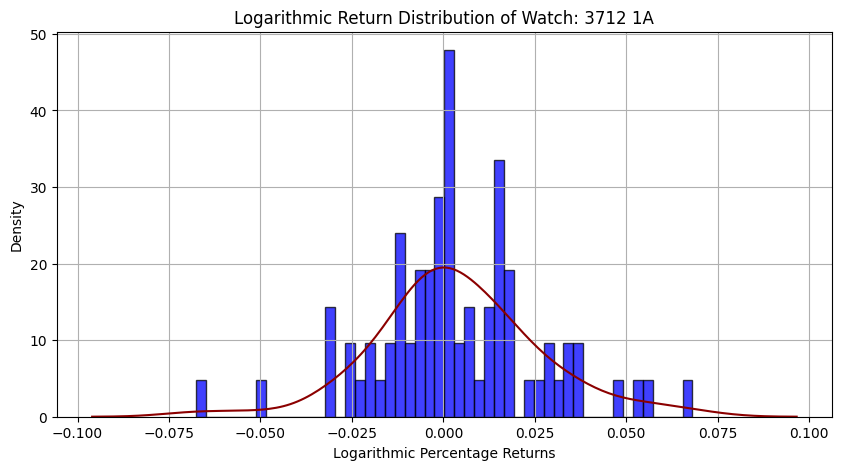

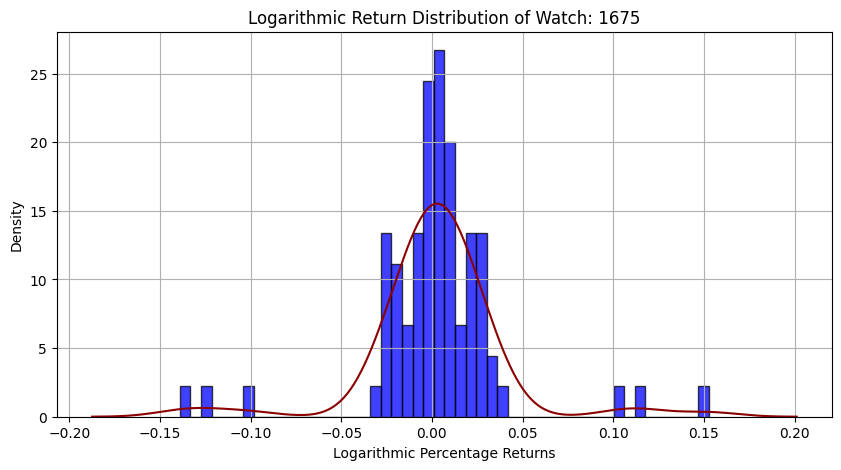

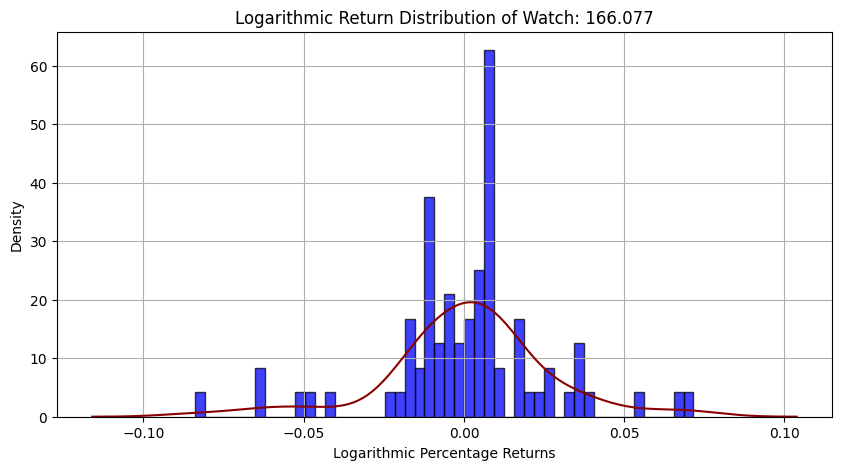

In [6]:
# Analyse Distribution of of weekly LN Returns
df_pct_change = watch_collection.get_dataframe()

for col in df_pct_change.columns:
    plt.figure(figsize=(10, 5))
    data = np.log(df_pct_change[col].dropna() + 1)
    plt.hist(data, bins=50, density=True, alpha=0.75, color='blue', edgecolor='black')
    sns.kdeplot(data, color='darkred')
    plt.title(f'Logarithmic Return Distribution of Watch: {col}')
    plt.xlabel('Logarithmic Percentage Returns')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

### Calculate and Visualize the Efficient Frontier

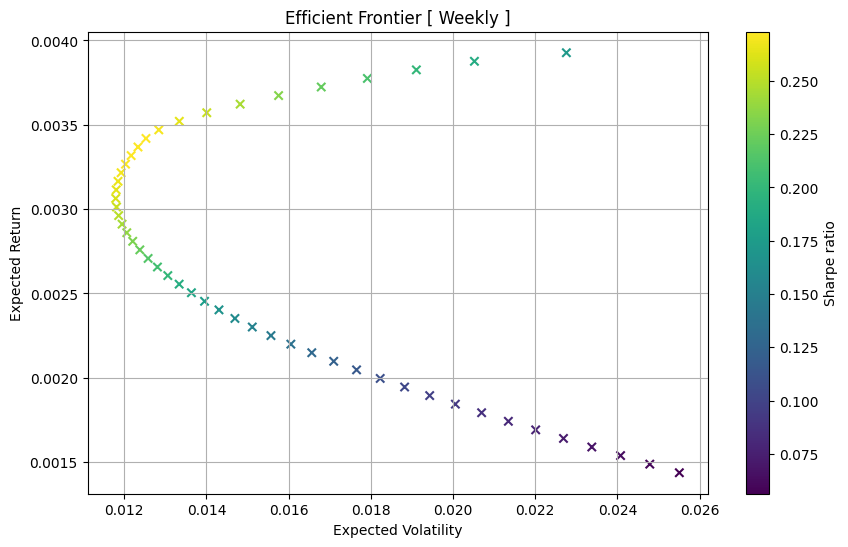

In [7]:
watch_collection.calculate_efficient_frontier()
watch_collection.plot_efficient_frontier()

### Show Minimal Variance Portfolio

weight: 0.53 of Watch: 16570 cal. 3186
weight: 0.2 of Watch: 3712 1A
weight: 0.11 of Watch: 1675
weight: 0.15 of Watch: 166.077


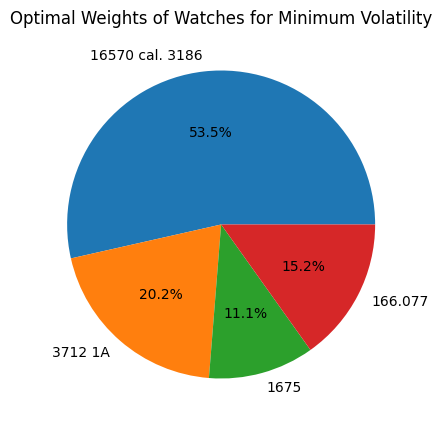

In [8]:
# Get the weights of the Minimum variance Portfolio and Visualiye in a PieChart
optimal_w = watch_collection.get_min_vol_weights()
watch_names = [param['name_reference'] for param in params_list]
weights = [round(w, 2) for w in optimal_w]

for i,param in enumerate(params_list):
    print(f"weight: {round(optimal_w[i],2)} of Watch: {param['name_reference']}")

plt.figure(figsize=(10, 5))
plt.pie(weights, labels=watch_names, autopct='%1.1f%%')
plt.title('Optimal Weights of Watches for Minimum Volatility')
plt.show()

## Conclusion
In this Group Project, we have implemented a Python code to analyze the performance of watches as investment assets. We have shown how to calculate the efficient frontier, which can be used to allocate investments optimally among different watches to maximize risk adjusted returns. 

Indeed, we must consider that watches can be evaluated in a similar fashion to stocks in terms of their investment potential. However, there are specific factors we need to be cognizant of while doing so. The temporal horizon and the quality of the dataset involved in this analysis play a significant role.

The time horizon affects the accuracy of our predictions, similar to stock investments. A short-term perspective might lead to misleading conclusions as fluctuations in watch prices might not necessarily reflect their long-term value. Therefore, the longer the time horizon, the more reliable the results.

Moreover, the quality of the dataset used in the analysis is paramount. A dataset with erroneous or insufficient information could lead to miscalculations of risk and returns, thus skewing our conclusions. Just like with stocks, we need a comprehensive and accurate dataset to perform a sound analysis, ensuring we capture the intricacies of the watch market.

In conclusion, our analysis offers a new perspective on viewing watches as viable investment assets. Nevertheless, a cautious approach should be maintained given the uniqueness of the watch market and the requirements of proper data quality and appropriate time horizon.

*(we used ChatGPT for better Wording)*